# SMARTER-OA-OARV3-top-20210323
Some preliminary considerations on result dataset after joining Texel UY and Frizarta data

In [1]:
import random
import itertools
import collections
import pandas as pd

from plinkio import plinkfile
from ensemblrest import EnsemblRest

from src.features.utils import get_processed_dir
from src.features.smarterdb import global_connection, VariantSheep

In [2]:
random.seed(a=42, version=2)
global_connection()
ensRest = EnsemblRest()

Collect informations from plink. Sort things to reproduce results

In [3]:
plink_path = get_processed_dir() / "OARV3" / "SMARTER-OA-OARV3-top-20210323"
plink_file = plinkfile.open(str(plink_path))
sample_list = plink_file.get_samples()
locus_list = plink_file.get_loci()
print(f"Got {len(sample_list)} samples from '{plink_path.name}'")
print(f"Read {len(locus_list)} SNPs")

Got 223 samples from 'SMARTER-OA-OARV3-top-20210323'
Read 54115 SNPs


Declare some useful functions:

In [4]:
def convert(genotype, locus):
    if genotype == 0:
        return f"{locus.allele1}/{locus.allele1}"
    elif genotype == 1:
        return f"{locus.allele1}/{locus.allele2}"
    elif genotype == 2:
        return f"{locus.allele2}/{locus.allele2}"
    elif genotype == 3:
        return f"0/0"
    else:
        raise Exception("Genotype %s Not supported" % genotype)

Select some snps and some individuals for furter analyses

In [5]:
indexes = random.sample(range(len(locus_list)), 10)
sample_subset = random.sample(sample_list, 2)

Collect info from Ensembl

In [6]:
loci = [locus_list[i] for i in indexes]
loci_names = [locus.name for locus in loci]
variants = [VariantSheep.objects(name=name).get() for name in loci_names ]
rs_ids = [variant.rs_id for variant in variants if variant.rs_id]
ens_data = ensRest.getVariationByMultipleIds(ids=rs_ids, species="ovis_aries", genotyping_chips=True)

In [7]:
data = collections.defaultdict(list)

for i, index in enumerate(indexes):
    # get locus
    locus = locus_list[index]
    variant = variants[i]
    location = variant.get_location(version='Oar_v3.1')
    
    # get genotype row from plink data. plink_file is unsuscriptable
    row = next(itertools.islice(plink_file, index, index+1))
    
    for sample, genotype in zip( sample_subset, row ):
        # print( "Individual {0} has genotype {1} for snp {2}: {3}".format( sample.iid, genotype, locus.name, convert(genotype, locus )))
        data["individual"].append(sample.iid)
        data["locus.name"].append(locus.name)
        data["rs_id"].append(variant.rs_id)
        data["chrom"].append(locus.chromosome)
        # the 'position' is the cM column!!!
        data["position"].append(int(locus.bp_position))
        data["genotype"].append(genotype)
        data["genotype_txt"].append(convert(genotype, locus ))
        data["illumina_top"].append(location.illumina_top)
        data["illumina_strand"].append(location.illumina_strand)
        data["alleles"].append(location.alleles)
        if variant.rs_id:
            # I could have more than one mappings
            ens_mapping = ens_data[variant.rs_id]['mappings'][0]
            data["ens_location"].append(ens_mapping['location'])
            data["ens_allele"].append(ens_mapping['allele_string'])
            data["ens_strand"].append(int(ens_mapping['strand']))
            data["ens_synonyms"].append(",".join(ens_data[variant.rs_id]['synonyms']))
            data["consequences"].append(ens_data[variant.rs_id]['most_severe_consequence'])
        else:
            data["ens_location"].append(None)
            data["ens_allele"].append(None)
            data["ens_strand"].append(None)
            data["ens_synonyms"].append(None)
            data["consequences"].append(None)
        
df = pd.DataFrame(data=data)
df

,individual,locus.name,rs_id,chrom,position,genotype,genotype_txt,illumina_top,illumina_strand,alleles,ens_location,ens_allele,ens_strand,ens_synonyms,consequences
0,UYOA-TEX-0120,OAR16_12144714.1,rs427283493,16,11146741,2,G/G,A/G,forward,C/T,16:11146741-11146741,T/C,1.0,OAR16_12144714.1,intergenic_variant
1,UYOA-TEX-0136,OAR16_12144714.1,rs427283493,16,11146741,2,G/G,A/G,forward,C/T,16:11146741-11146741,T/C,1.0,OAR16_12144714.1,intergenic_variant
2,UYOA-TEX-0120,s06844.1,rs415332244,1,64969397,2,G/G,A/G,forward,C/T,1:64969397-64969397,T/C,1.0,s06844.1,intergenic_variant
3,UYOA-TEX-0136,s06844.1,rs415332244,1,64969397,2,G/G,A/G,forward,C/T,1:64969397-64969397,T/C,1.0,s06844.1,intergenic_variant
4,UYOA-TEX-0120,OAR21_29098780.1,None,0,0,2,G/G,A/G,None,None,None,None,NaN,None,None
5,UYOA-TEX-0136,OAR21_29098780.1,None,0,0,2,G/G,A/G,None,None,None,None,NaN,None,None
6,UYOA-TEX-0120,OAR22_5540854.1,rs417255720,22,4407671,2,G/G,A/G,forward,C/T,22:4407671-4407671,C/T,1.0,OAR22_5540854.1,intron_variant
7,UYOA-TEX-0136,OAR22_5540854.1,rs417255720,22,4407671,2,G/G,A/G,forward,C/T,22:4407671-4407671,C/T,1.0,OAR22_5540854.1,intron_variant
8,UYOA-TEX-0120,OAR3_93361211.1,rs401857314,3,88184583,0,A/A,A/G,forward,A/G,3:88184583-88184583,G/A,1.0,OAR3_93361211.1,intergenic_variant
9,UYOA-TEX-0136,OAR3_93361211.1,rs401857314,3,88184583,0,A/A,A/G,forward,A/G,3:88184583-88184583,G/A,1.0,OAR3_93361211.1,intergenic_variant


How many missing data I have?

,Missing SNPs
UYOA-TEX-0007,7912
UYOA-TEX-0051,7627
UYOA-TEX-0052,7928
UYOA-TEX-0080,7024
UYOA-TEX-0016,3464
...,...
GROA-FRZ-0218,1614
GROA-FRZ-0220,1994
GROA-FRZ-0221,1506
GROA-FRZ-0222,1598


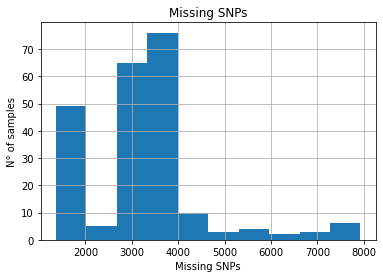

In [8]:
missing = collections.Counter()

for locus, row in zip( locus_list, plink_file ):
    for sample, genotype in zip( sample_list, row ):
        if genotype == 3:
            missing.update([sample.iid])

missing = pd.DataFrame.from_dict(missing, orient='index')
missing = missing.rename(columns={0: "Missing SNPs"})
plt = missing.hist()
# https://stackoverflow.com/a/42833552/4385116
for ax in plt.flatten():
    ax.set_xlabel("Missing SNPs")
    ax.set_ylabel("N° of samples")
missing